In [1]:
import numpy as np
import astropy.io.fits as pyfits
from astropy.table import Table
import pylab
import matplotlib.pyplot as plt
import pandas as pd
import csv
from IPython.display import Image

In [2]:
infile_redmagic = 'Data/y3_gold_2.2.1_wide_sofcol+deep_mof_run_redmagic_highdens.fit'
reader_redmagic = pyfits.open(infile_redmagic)
d_redmagic = reader_redmagic[1].data
data = Table.read(infile_redmagic, format='fits')
data.info

<Table length=2766815>
     name       dtype  shape
-------------- ------- -----
            id   int64      
            ra float64      
           dec float64      
        refmag float32      
    refmag_err float32      
           mag float32  (4,)
       mag_err float32  (4,)
           lum float32      
     zredmagic float32      
   zredmagic_e float32      
zredmagic_samp float32  (4,)
         chisq float32      
         zspec float32      

In [3]:
d_redmagic = d_redmagic[d_redmagic['zspec'] > 0.] #otherwise there is no data for z
d_redmagic = d_redmagic[d_redmagic['dec'] > -10.]
print(len(d_redmagic))

49290


In [4]:
reader_boss = pyfits.open('data/sdss_velocity_dispersion.fits')
d_veldisp = reader_boss[1].data
data = Table.read('data/sdss_velocity_dispersion.fits', format='fits')
data.info

<Table length=1169508>
   name     dtype 
---------- -------
        ra float64
       dec float64
         z float32
      zErr float32
   velDisp float32
velDispErr float32

In [5]:
d_veldisp = d_veldisp[d_veldisp['dec'] < 10.]
selection = np.logical_not((d_veldisp['ra'] > 90.) & (d_veldisp['ra'] < 270.))
selection = selection & ((d_veldisp['velDisp'] / d_veldisp['velDispErr']) > 5.)
d_veldisp = d_veldisp[selection]
print(len(d_veldisp))

117545


/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


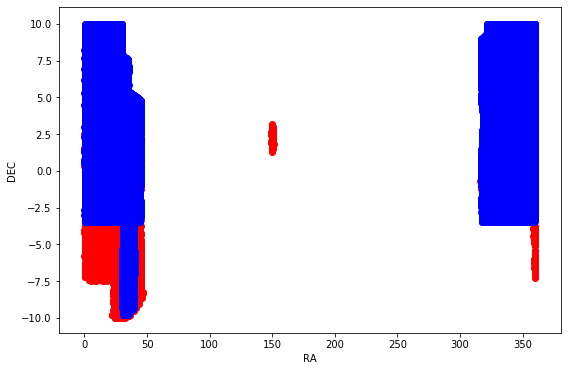

In [6]:
pylab.figure(figsize=(9,6))
plt.xlabel('RA')
plt.ylabel('DEC')
pylab.scatter(d_redmagic['ra'], d_redmagic['dec'], c='red')
pylab.scatter(d_veldisp['ra'], d_veldisp['dec'], c='blue')
plt.show()

In [7]:
def write_files(c2_ra, c2_dec):
    l, num = 0, int(len(c2_ra)/1000)+1 #l is going to be the counter from 0 to 1000, num is the number of files with 1000 rows
    for j in range(1,num+1):
        with open('Data/coordinates{}.csv'.format(j), mode='w') as coordinates_sep: #Create each file
            writer = csv.writer(coordinates_sep, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['RA', 'DEC'])
            mini = (j-1)*1000
            maxi = mini + 999
            for i in range(mini,maxi+1):
                writer.writerow([c2_ra[i], c2_dec[i]])
                l+=1
                if(l==1000):
                    l=0
                    break
                if(i>=len(c2_ra)-1):
                    break

In [8]:
from astropy.coordinates import SkyCoord
from astropy import units as u

def write_galaxies_file(lon1, ra1, lon2, ra2, sep, redshift_SD, vel_disp, coadd_id):
    #Input coordinates and max separation in decimal degrees, redshift from SDSS and velocity of dispersion
    c1 = SkyCoord(ra=lon1*u.degree, dec=lat1*u.degree) #specify units
    c2 = SkyCoord(ra=lon2*u.degree, dec=lat2*u.degree) #specify units
    max_sep = sep*u.arcsec
    # idx_1 indices of c1 whose objects are the closest to each of the objects in c2 (size of c2, c1 indices)
    # d2d are the on-sky distances between them
    idx_1, d2d, d3d = c2.match_to_catalog_3d(c1) 

    sep_constraint = d2d < max_sep #boolean list: True when the separation is less than the max separation
    idx_2 = np.nonzero(sep_constraint)[0] #indices of the elements that are 'True' in the boolean list, indices of c2
    idx_1 = idx_1[sep_constraint] #Indices of c1 that satisfy the maximum separation constraint
    d2d = d2d[sep_constraint].value #Value of separation of objects that satisfy the maximum separation constraint

    df = pd.DataFrame({'index': idx_1, 'sep': d2d}) #Create data frame: |C1 Index| Separation|  (with sep constraint)
    grupo = df.groupby(['index']) #Group by C1 index (Groups of separation values that have the same C1 index)
    idx = grupo.idxmin().values.astype(int) #Takes into account only the closest match

    idx_1, idx_2, d2d = idx_1[idx], idx_2[idx], d2d[idx] #Unique indices of C1 (match unique objects of catalogs)

    c2_ra, c2_dec = c2.ra.degree[np.array(idx_2[:,0])], c2.dec.degree[np.array(idx_2[:,0])]
    vel_disp = vel_disp[np.array(idx_1[:,0])]
    coadd_id = coadd_id[np.array(idx_2[:,0])]
    redshift_SD = redshift_SD[np.array(idx_1[:,0])]
    write_files(c2_ra, c2_dec)
    with open('Data/data.csv', mode='w') as coordinates_sep:
        writer = csv.writer(coordinates_sep, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['ID', 'RA', 'DEC', 'SEP', 'VEL_DISP', 'z'])
        for i in range(len(c2_ra)):
            writer.writerow([coadd_id[i], c2_ra[i], c2_dec[i], d2d[i][0], vel_disp[i], redshift_SD[i]])

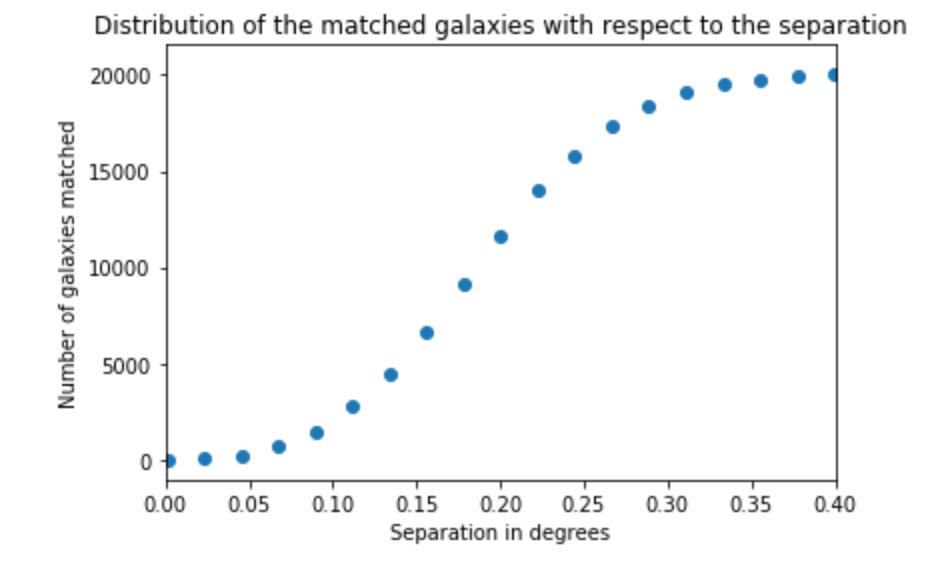

In [9]:
# Actually the separation is in arc seconds
Image(filename='Data/Distribution matched galaxies (zoom).png', width = 500, height= 500)

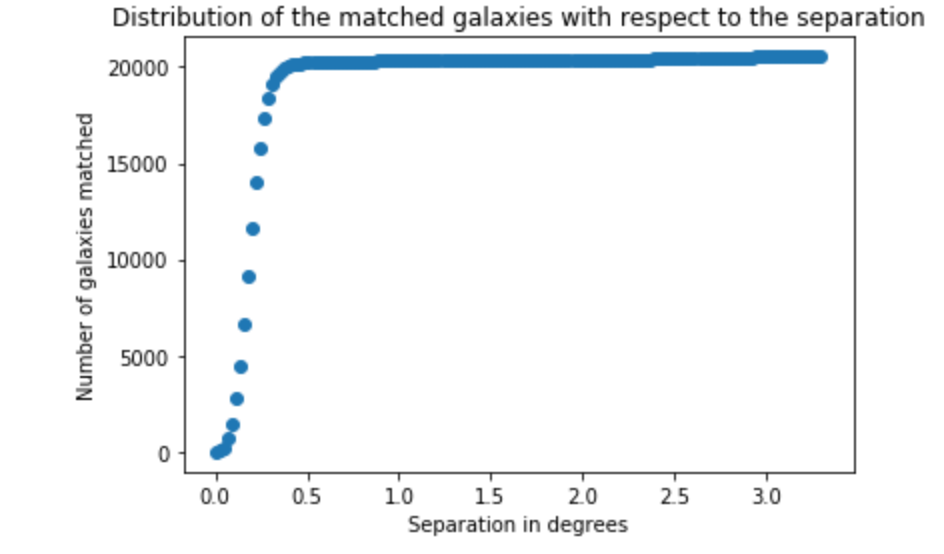

In [10]:
# Actually the separation is in arc seconds
Image(filename='Data/Distribution matched galaxies.png', width = 500, height= 500)

In [11]:
lat1, lon1 = d_veldisp['dec'], d_veldisp['ra'] #SDSS
lat2, lon2 = d_redmagic['dec'], d_redmagic['ra'] #Red Magic
redshift_SD, vel_disp, coadd_id = d_veldisp['z'], d_veldisp['velDisp'], d_redmagic['id']
sep = 1 #in Arcseconds
write_galaxies_file(lon1, lat1, lon2, lat2, sep, redshift_SD, vel_disp, coadd_id)